In [1]:
# tar -xvzf /path/to/yourfile.tgz -C /path/where/to/extract/
# tar -xvzf /home/jtoledo/ATLAS-dataset/15012/photon_samples.tgz -C ./photon_samples/
using CSV, DataFrames, Plots, Statistics, HDF5, Random

In [2]:
function loadCSVs(; keyword = "photons_samples_highStat")
    files = readdir("/raid/javier/Datasets/CaloVAE/data/$(keyword)/", join=true)
    ar = Array(CSV.read(files[1], DataFrame))
    en_in_file = parse(Float64, split(split(files[1], "_eta_")[1], "_E")[2])
    enInit = [en_in_file for i in 1:size(ar,1)]
    for file in files[2:end]
        @info file
        tmp = Array(CSV.read(file, DataFrame))
        if file == "/raid/javier/Datasets/CaloVAE/data/$(keyword)/pid22_E8192_eta_20_25_voxalisation.csv" # Missing values in last event
            tmp = tmp[1:end-1,:]
        end
        ar = vcat(ar, tmp)
        en_in_file = parse(Float64, split(split(file, "_eta_")[1], "_E")[2])
        enInit = vcat(enInit, [en_in_file for i in 1:size(tmp,1)])
    end
    ar[typeof.(ar) .!= Float64] = parse.(Float64, ar[typeof.(ar) .!= Float64])
    ar = Array{Float64}(ar')
    return ar, enInit
end

loadCSVs (generic function with 1 method)

In [45]:
function filterByEnergy(events, energy_inc, energy=256)
    idx = findall(x->x == energy, energy_inc)
    if isempty(idx)
        @warn "try an energy power of 2."
        return [0], [0]
    else
        return events[:,idx], energy_inc[idx]
    end
end

filterByEnergy (generic function with 2 methods)

In [132]:
function savePerEnergy(events0, energy_inc0, energy=256, keyword="photons_highStat")
    events, energy_inc = filterByEnergy(events0, energy_inc0, energy)
    clamp!(events,0, Inf)
    energy_in_Vox = sum(events, dims=1)
    logEnergy256 = Int(log2(energy/256))
    h5open("/raid/javier/Datasets/CaloVAE/data/atlas/$(keyword)_En_$(logEnergy256).hdf5", "w") do file
        write(file, "voxels", events)
        write(file, "energy_from_voxels", energy_in_Vox)
        write(file, "energy", Array(energy_inc'))
    end
end

savePerEnergy (generic function with 3 methods)

In [133]:
function datasetPerEnergyFromCSV(keyword="photons_samples_highStat")
    events0, energy_inc0 = loadCSVs(; keyword)
    for energy in sort(unique(energy_inc0))
        @info energy, keyword
        savePerEnergy(events0, energy_inc0, energy, keyword)
    end
end

datasetPerEnergyFromCSV (generic function with 3 methods)

In [138]:
datasetPerEnergyFromCSV("photons_samples_highStat")
# datasetPerEnergyFromCSV("pions_samples_highStat")

[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E1048576_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E131072_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E16384_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E2048_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E2097152_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E256_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E262144_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E32768_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datasets/CaloVAE/data/photons_samples_highStat/pid22_E4096_eta_20_25_voxalisation.csv
[ Info: /raid/javier/Datas

In [ ]:
events, energy_inc = filterByEnergy(events0, energy_inc0, 256)
energy_in_Vox = sum(events, dims=1)

In [ ]:
# function createH5(; keyword = "photon_samples", enScale = 1.0, group1 = "voxels", group2 = "energy", group3="energy_from_voxels")
# #     files = readdir(pwd() * "/15012/$(keyword)/", join=true)
#     files = readdir("/fast_scratch/QVAE/data/atlas/$(keyword)/", join=true)
#     ar = Array(CSV.read(files[1], DataFrame))
#     en_in_file = parse(Float64, split(split(files[1], "_eta_")[1], "_E")[2])
#     enInit = [en_in_file for i in 1:size(ar,1)]
#     for file in files[2:end]
#         @info file
#         tmp = Array(CSV.read(file, DataFrame))
# #         if file == pwd() * "/15012/$(keyword)/pid22_E8192_eta_20_25_voxalisation.csv" # Missing values in last event
#         if file == "/fast_scratch/QVAE/data/atlas/$(keyword)/pid22_E8192_eta_20_25_voxalisation.csv" # Missing values in last event
#             tmp = tmp[1:end-1,:]
#         end
#         ar = vcat(ar, tmp)
#         en_in_file = parse(Float64, split(split(file, "_eta_")[1], "_E")[2])
#         enInit = vcat(enInit, [en_in_file for i in 1:size(tmp,1)])
#     end
#     ar[typeof.(ar) .!= Float64] = parse.(Float64, ar[typeof.(ar) .!= Float64])
#     ar = Array{Float64}(ar')
# #     idx = randperm(size(ar,2))
# #     ar = ar[:,idx]
#     en = sum(ar, dims=1) #./ enScale
# #     isdir(pwd() * "/HDF5-files/") || mkpath(pwd() * "/HDF5-files/")
#     h5open("/fast_scratch/QVAE/data/atlas/$(keyword).hdf5", "w") do file
#         write(file, group1, ar)  # alternatively, say "@write file A"
#         write(file, group2, reshape(enInit, 1,:))
#         write(file, group3, en)
#     end
# end

In [ ]:
####################### Zenodo https://zenodo.org/record/6368338

In [2]:
function readHDF5Files(PATH="/raid/javier/Datasets/CaloVAE/data/atlas/", FILENAME="dataset_1_photons_1.hdf5")
    path = PATH * FILENAME
    data = h5open(path);
    dataset = Dict()
    for key in keys(data)
        dataset[key] = h5read(path, key);
    end
    return dataset
end

readHDF5Files (generic function with 3 methods)

In [6]:
function reparseData(FILENAME, FILENAMETO, PATH="/fast_scratch/QVAE/data/atlas/")
    dataset = readHDF5Files(PATH, FILENAME)
    totEn = sum(dataset["showers"], dims=1)
    h5open(PATH * FILENAMETO, "w") do file
        write(file, "voxels", dataset["showers"])
        write(file, "energy", dataset["incident_energies"])
        write(file, "energy_from_voxels", totEn)
    end
end

reparseData (generic function with 2 methods)

In [10]:
# reparseData("dataset_1_photons_1.hdf5", "photons1.hdf5")

"photons1.hdf5"

In [41]:
PATH = "/raid/javier/Datasets/CaloVAE/data/atlas/"
FILENAME = "photons1.hdf5"
dataset = readHDF5Files(PATH, FILENAME);

In [ ]:
#Split per Energy

In [42]:
function datasetPerEnergy(PATH="/raid/javier/Datasets/CaloVAE/data/atlas/", FILENAME="photons1.hdf5")
    dataset = readHDF5Files(PATH, FILENAME)
    for energy in sort(unique(dataset["energy"]))
        idxForEnergy = findall(x->x == energy, dataset["energy"][1,:])
        ar = dataset["voxels"][:,idxForEnergy]
        en = dataset["energy"][:,idxForEnergy]
        enVox = dataset["energy_from_voxels"][:,idxForEnergy]
        logEnergy256 = Int(log2(energy/256))
        FILENAMETO = split(FILENAME, ".")[1] * "_En_$(logEnergy256).hdf5"
        h5open(PATH * FILENAMETO, "w") do file
            write(file, "voxels", ar)
            write(file, "energy", en)
            write(file, "energy_from_voxels", enVox)
        end
        @info size(idxForEnergy,1), FILENAMETO
    end
end

datasetPerEnergy (generic function with 3 methods)

In [43]:
PATH = "/raid/javier/Datasets/CaloVAE/data/atlas/"
FILENAME = "pions1.hdf5"
datasetPerEnergy(PATH, FILENAME)

[ Info: (10000, "pions1_En_0.hdf5")
[ Info: (10000, "pions1_En_1.hdf5")
[ Info: (10000, "pions1_En_2.hdf5")
[ Info: (10000, "pions1_En_3.hdf5")
[ Info: (10000, "pions1_En_4.hdf5")
[ Info: (10000, "pions1_En_5.hdf5")
[ Info: (10000, "pions1_En_6.hdf5")
[ Info: (10000, "pions1_En_7.hdf5")
[ Info: (10000, "pions1_En_8.hdf5")
[ Info: (10000, "pions1_En_9.hdf5")
[ Info: (10000, "pions1_En_10.hdf5")
[ Info: (5000, "pions1_En_11.hdf5")
[ Info: (3000, "pions1_En_12.hdf5")
[ Info: (2000, "pions1_En_13.hdf5")
[ Info: (230, "pions1_En_14.hdf5")


In [85]:
#Data Verification

In [19]:
PATH = "/raid/javier/Datasets/CaloVAE/data/atlas/"
# FILENAME = "pions_samples_highStat_En_5.hdf5"
# FILENAME = "pions1.hdf5"
PATH = "/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/"
FILENAME = "dataset_2_1.hdf5"
dataset = readHDF5Files(PATH, FILENAME);

In [20]:
# size(dataset["incident_energies"])
# dataset
size(dataset["showers"],1)

6480

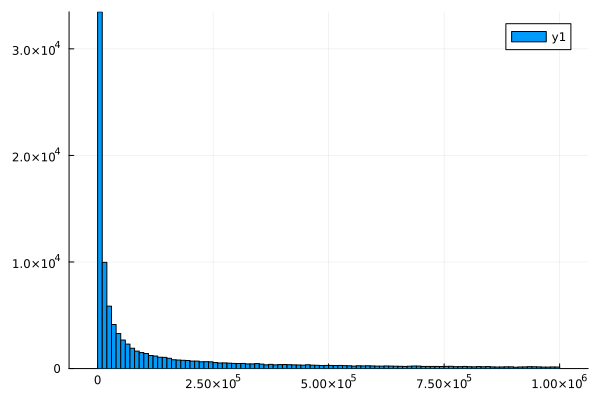

In [11]:
plot(dataset["incident_energies"][1,:], st=:histogram)

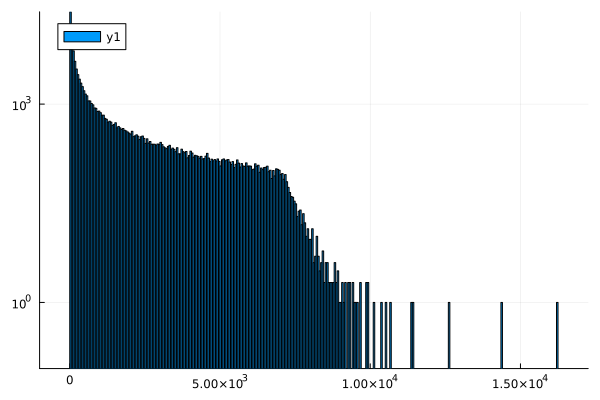

In [13]:
plot(sum(dataset["showers"], dims=1)[:], st=:histogram, yscale=:log10)

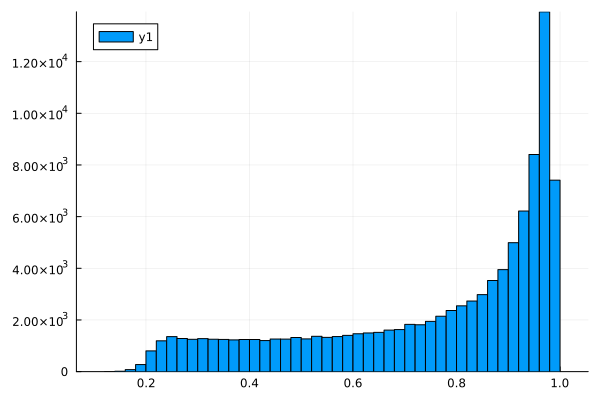

In [14]:
plot(sum(dataset["showers"] .== 0, dims=1)[:]/size(dataset["showers"],1), st=:histogram)

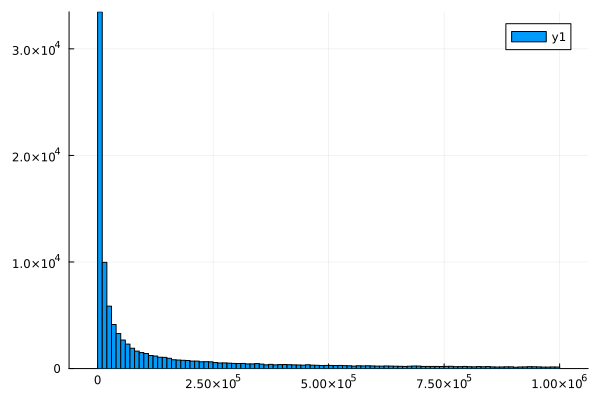

In [5]:
# plot(dataset["energy_from_voxels"][1,:], st=:histogram)
plot(dataset["incident_energies"][1,:], st=:histogram)

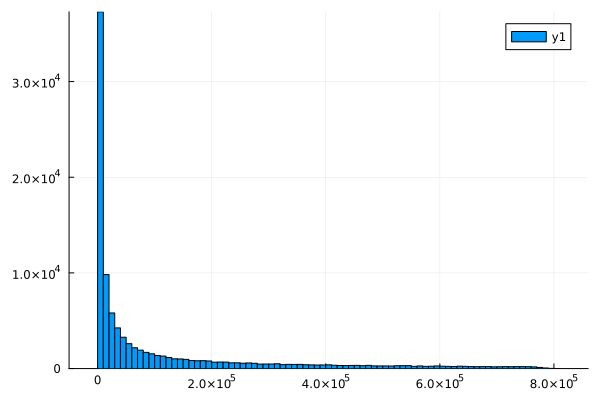

In [6]:
# plot(sum(dataset["voxels"], dims=1)[:], st=:histogram)
plot(sum(dataset["showers"], dims=1)[:], st=:histogram)

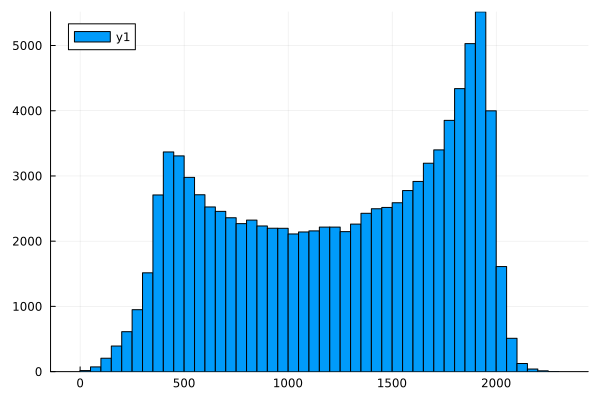

In [22]:
plot(sum(log.(1 .+ dataset["showers"] ./ dataset["incident_energies"] ./ 0.00017), dims=1)[:], st=:histogram)

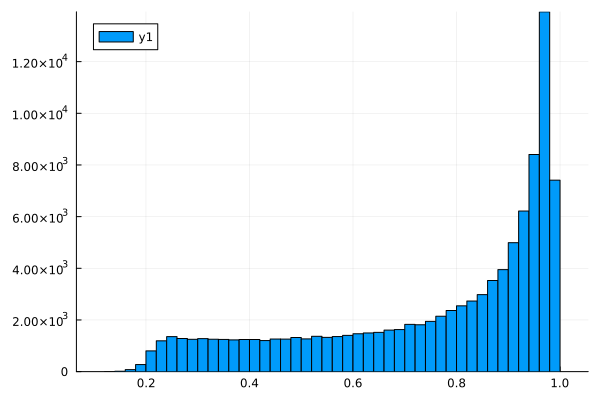

In [9]:
plot(sum(dataset["showers"] .== 0, dims=1)[:]/size(dataset["showers"],1), st=:histogram)

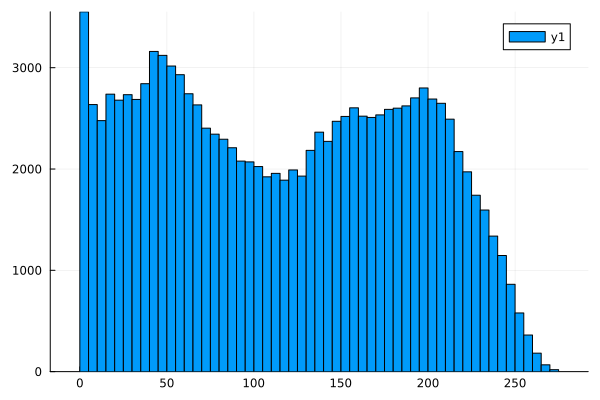

In [26]:
plot(sum(log.(1 .+ dataset["voxels"] ./ dataset["energy"] ./ 0.002), dims=1)[:], st=:histogram)

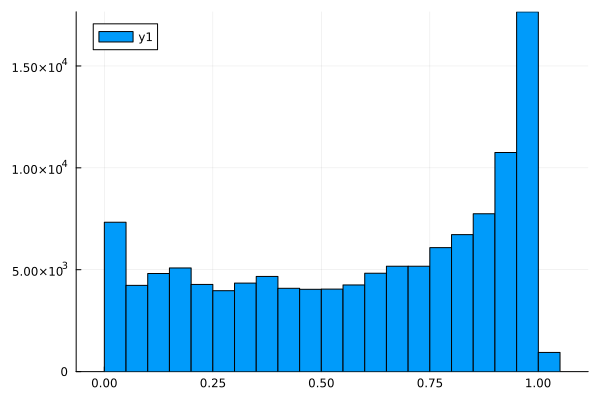

In [31]:
plot(sum(dataset["voxels"] .== 0, dims=1)[:]/533, st=:histogram)

In [15]:
0.002*533/6040

0.00017649006622516558

In [139]:
PATH = "/raid/javier/Datasets/CaloVAE/data/atlas/"
enVoxm = []
enVoxstd = []
en = []
for i in 0:7
    FILENAME = "pions_samples_highStat_En_$i.hdf5"
    dataset = readHDF5Files(PATH, FILENAME);
    append!(en, dataset["energy"][1,1])
    append!(enVoxm, mean(dataset["energy_from_voxels"][1,:]))
    append!(enVoxstd, std(dataset["energy_from_voxels"][1,:]))
end 

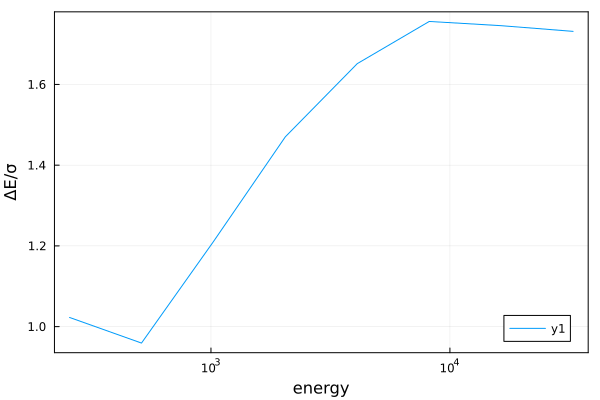

In [113]:
plot(en, (en .- enVoxm) ./ enVoxstd, xscale=:log10, xlabel="energy", ylabel="ΔE/σ", frame=:box)

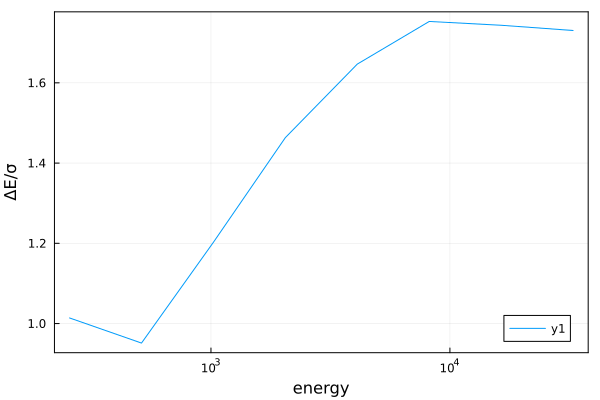

In [140]:
plot(en, (en .- enVoxm) ./ enVoxstd, xscale=:log10, xlabel="energy", ylabel="ΔE/σ", frame=:box)

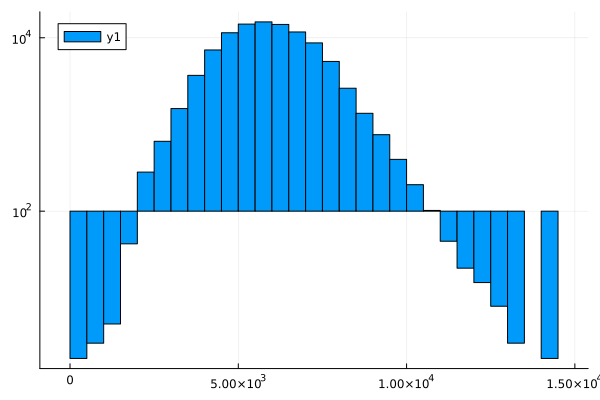

In [34]:
# plot(dataset["energy_from_voxels"][1,:] , st=:histogram, yscale=:log10)
plot(dataset["energy_from_voxels"][1,:] .+ 10 , st=:histogram, yscale=:log10, bins=50)